# MLA 703. RNN-LSTM et architectures avancées [Analyse de sentiment]

In [ ]:
# Dans ce notebook, nous allons nous intéresser à des tâches d'analyse de sentiments
# -> c'est à dire prédire un label de sentiment (ici positif ou négatif) à partir d'un texte

# Ce notebook vise à approfondir :
# - L'application du DL sur des données textuelles
# - La compréhension des architectures RNN avancées comme les LSTM et les mécanismes d'attention
#

# 1. Importation des modules

In [ ]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


## 1. Charger les données

## 2. Formater/Préparer les données

In [ ]:
# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words,
                                                      maxlen=max_len)


In [ ]:
# Visualiser les dimension de la base d'apperrentissage et la base de test.
print(f"Ensemble de données chargé avec {len(x_train)} échantillons d'apprentissage, {len(x_test)} de test")

Ensemble de données chargé avec 2773 échantillons d'apprentissage, 2963 de test


In [ ]:
# Mapping des commentaires sur des mots d'origine
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}

for seq, i in zip(x_train[:10], range(10)):
    print('---review with words---')
    print([id2word.get(i, ' ') for i in seq])
    print('---label---')
    print(y_train[i])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences

print("La phrase avant padding est : \n {}".format(x_train[0]))

# On padde les séquence de mot
max_len       = 100
x_train       = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test        = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))

print(len(x_train))

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
2773


In [ ]:
print('---review with words---')
print([id2word.get(i, ' ') for i in x_train[0]])
print('---label---')
print(y_train[0])

---review with words---
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'the', 'effort', 'still', 'been', 'that', 'usually', 'makes', 'for', 'of', 'finished', 'and', 'ended', 'and', 'an', 'because', 'before', 'if', 'just', 'though', 'something', 'know', 'novel', 'female', 'i', 'i', 'slowly', 'lot', 'of', 'above', 'and', 'with', 'connect', 'in', 'of', 'script', 'their', 'that', 'out', 'end', 'his', 'and', 'i', 'i']
---label---
0


## 3. Déclaration du réseau

La tâche consiste à prédire la valence d'un texte à partir de son contenu.
Pour ce faire nous allons créer une architecture many-to-one
avec les réseaux RNNs
Le problème consiste à implémenter et apprendre
des réseaux avec - par exemple - les configurations suivantes :
On va comparer les configurations suivantes :
- Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)
- RNN-LSTM gauche-droite classique
- LSTM bi-directionnel et return_sequences = False
- Plusieurs couches au choix. On veillera en particulier
  à la valeur des arguments return_sequences
  
Dans le rapport à faire directement dans le notebook, on prendra soin de :
- reporter les losses sur les ensembles d'entrainement et de validation
- mesurer l'accuracy sur l'ensemble de test
On commentera les résultats obtenus en comparant les configurations
Quelle est la configuration donnant la meilleure performance ?
Pourquoi ?

Aide : une couche LSTM bi-directionnelle est obtenue en appliquant sur la même couche une couche LSTM et une couche Bidirectional

In [ ]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
#from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model = Sequential()
model.add(Embedding(num_words, embed_size))                 # layer embedding
model.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
model.add(Dropout(0.25))                                    # layer Dropout
model.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         640000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________


## 4. Entrainement du réseau

In [ ]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 2s 31ms/step - loss: 3.4976 - accuracy: 0.4761 - val_loss: 0.7921 - val_accuracy: 0.4468
Epoch 2/10
35/35 [==============================] - 1s 26ms/step - loss: 0.9444 - accuracy: 0.6240 - val_loss: 0.7884 - val_accuracy: 0.5153
Epoch 3/10
35/35 [==============================] - 1s 24ms/step - loss: 0.4620 - accuracy: 0.8097 - val_loss: 0.7995 - val_accuracy: 0.5081
Epoch 4/10
35/35 [==============================] - 1s 27ms/step - loss: 0.2796 - accuracy: 0.9098 - val_loss: 1.1776 - val_accuracy: 0.5261
Epoch 5/10
35/35 [==============================] - 1s 25ms/step - loss: 0.1107 - accuracy: 0.9748 - val_loss: 1.3606 - val_accuracy: 0.5333
Epoch 6/10
35/35 [==============================] - 1s 32ms/step - loss: 0.0474 - accuracy: 0.9950 - val_loss: 1.9717 - val_accuracy: 0.5171
Epoch 7/10
35/35 [==============================] - 1s 22ms/step - loss: 0.0262 - accuracy: 0.9991 - val_loss: 2.1273 - val_accuracy: 0.5189
Epoch 8/10
35

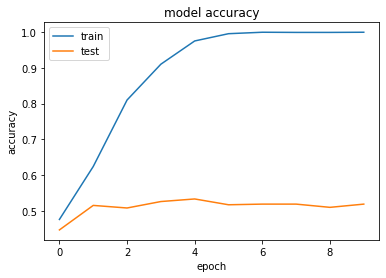

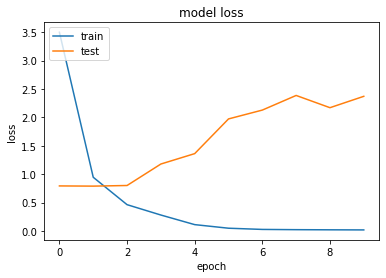

In [ ]:
# On trace la loss et l'accuracy du modèle
# On trace l'évolution de l'accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# On trace l'évolution de la loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history

# On prédit sur l'ensemble de test

# On prédit sur les données de test
y_hat = model.predict(x_test)

# On tranforme les prédictions en labels
i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

y_pred   = np.zeros(len(y_hat))
y_pred[i_pos] = 1
y_pred[i_neg] = 0


In [ ]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)


La matrice de confusion sur le jeu de test :
 [[ 135 1224]
 [ 102 1502]] 

L accuracy sur le jeu de test est :
 0.5524805939925751


# LSTM

Nous allons commencer avec un RNN alimenté par LSTM.

Pour exploiter la puissance de la cellule LSTM (la cellule LSTM et la couche LSTM sont souvent utilisées de manière interchangeable) dans TensorFlow, nous utiliserons `tensorflow.keras.layers.LSTM()`

Notre modèle va prendre une structure très similaire à `model`:  


`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`  
La principale différence sera que nous allons ajouter une couche LSTM entre notre intégration et notre sortie.

In [ ]:
def plot_history(history):
    # On trace l'évolution de l'accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # On trace l'évolution de la loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM
tf.random.set_seed(42)

num_words = 5000
embed_size = 128
max_len = 100
LMST_size = 64

# Example d'architecture pour le réseau LSTM avec dropout
model1_LMST = Sequential()
model1_LMST.add(Embedding(  input_dim=num_words,   # 5000
                            output_dim=embed_size, # 128
                            embeddings_initializer="uniform",
                            input_length=max_len,  # 100
                            name="embedding_model1_LMST"    ))    # layer embedding
model1_LMST.add(LSTM(   units = LMST_size,
                        activation='tanh',
                        recurrent_activation='sigmoid',
                        return_sequences=False,
                        return_state=False,
                        stateful=False  ))    # layer LMST

#model1_LMST.add(Dropout(0.25))  # layer Dropout
model1_LMST.add(Dense(10, activation="relu"))  # layer Dense
#model1_LMST.add(Dropout(0.25))  # layer Dropout
model1_LMST.add(Dense(1, activation="sigmoid"))  # layer Dense

# On affiche l'architecture de notre modèle
model1_LMST.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model1_LMST.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_model1_LMST (Embe  (None, 100, 128)         640000    
 dding)                                                          
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_14 (Dense)            (None, 10)                650       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 690,069
Trainable params: 690,069
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# On entraine le réseau
batch_size = 64         # tailles des mini-batch
epochs = 10             # nombre d'époques
history_model1_LMST = model1_LMST.fit(  x_train,
                                        y_train,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 5s 71ms/step - loss: 0.6714 - accuracy: 0.6005 - val_loss: 0.6040 - val_accuracy: 0.7658
Epoch 2/10
35/35 [==============================] - 2s 72ms/step - loss: 0.4070 - accuracy: 0.8530 - val_loss: 0.3398 - val_accuracy: 0.8450
Epoch 3/10
35/35 [==============================] - 2s 64ms/step - loss: 0.1647 - accuracy: 0.9418 - val_loss: 0.3235 - val_accuracy: 0.8486
Epoch 4/10
35/35 [==============================] - 2s 64ms/step - loss: 0.0815 - accuracy: 0.9797 - val_loss: 0.3632 - val_accuracy: 0.8577
Epoch 5/10
35/35 [==============================] - 2s 61ms/step - loss: 0.0369 - accuracy: 0.9919 - val_loss: 0.5250 - val_accuracy: 0.8432
Epoch 6/10
35/35 [==============================] - 2s 60ms/step - loss: 0.0625 - accuracy: 0.9797 - val_loss: 0.4207 - val_accuracy: 0.8432
Epoch 7/10
35/35 [==============================] - 2s 59ms/step - loss: 0.0245 - accuracy: 0.9941 - val_loss: 0.5046 - val_accuracy: 0.8396
Epoch 8/10
35

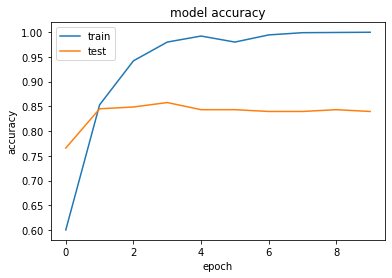

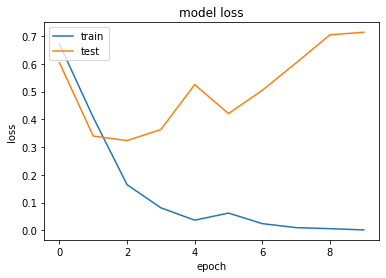

In [ ]:
plot_history(history_model1_LMST)

In [ ]:
# # Example d'architecture pour le réseau LSTM avec dropout
# model2_LMST = Sequential()
# model2_LMST.add(Embedding(  input_dim=num_words,   # 5000
#                             output_dim=embed_size, # 128
#                             embeddings_initializer="uniform",
#                             input_length=max_len,  # 100
#                             name="embedding_model1_LMST"    ))    # layer embedding

# model2_LMST.add(Bidirectional(LSTM( units = LMST_size,
#                                     return_sequences=True)))    # layer LMST
# model2_LMST.add(Bidirectional(LSTM( units = LMST_size,
#                                     return_sequences=False)))
# model2_LMST.add(Dense(64, activation="relu"))  # layer Dense
# model2_LMST.add(Dropout(0.5))
# model2_LMST.add(Dense(1, activation="sigmoid"))  # layer Dense


# # On affiche l'architecture de notre modèle
# model2_LMST.summary()
# # On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
# model2_LMST.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



# Example d'architecture pour le réseau LSTM avec dropout
model2_LMST = Sequential()
model2_LMST.add(Embedding(  input_dim=num_words,   # 5000
                            output_dim=embed_size, # 128
                            embeddings_initializer="uniform",
                            input_length=max_len,  # 100
                            name="embedding_model1_LMST"    ))    # layer embedding

model2_LMST.add(Bidirectional(LSTM( units = LMST_size,
                                    return_sequences=True)))    # layer LMST
model2_LMST.add(Bidirectional(LSTM( units = LMST_size,
                                    return_sequences=False)))
model2_LMST.add(Dense(2, activation="relu"))  # layer Dense
model2_LMST.add(Dropout(0.5))
model2_LMST.add(Dense(2, activation="relu"))  # layer Dense
model2_LMST.add(Dropout(0.5))
model2_LMST.add(Dense(1, activation="sigmoid"))  # layer Dense


# On affiche l'architecture de notre modèle
model2_LMST.summary()
# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model2_LMST.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_model1_LMST (Embe  (None, 100, 128)         640000    
 dding)                                                          
                                                                 
 bidirectional_7 (Bidirectio  (None, 100, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 2)                 258       
                                                                 
 dropout_15 (Dropout)        (None, 2)                 0         
                                                     

In [ ]:
# On entraine le réseau
batch_size = 64         # tailles des mini-batch
epochs = 10             # nombre d'époques
history_model2_LMST = model2_LMST.fit(  x_train,
                                        y_train,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 11s 187ms/step - loss: 0.6929 - accuracy: 0.5293 - val_loss: 0.6921 - val_accuracy: 0.5676
Epoch 2/10
35/35 [==============================] - 7s 188ms/step - loss: 0.6920 - accuracy: 0.5509 - val_loss: 0.6909 - val_accuracy: 0.5676
Epoch 3/10
35/35 [==============================] - 9s 251ms/step - loss: 0.6911 - accuracy: 0.5509 - val_loss: 0.6900 - val_accuracy: 0.5676
Epoch 4/10
35/35 [==============================] - 11s 307ms/step - loss: 0.6905 - accuracy: 0.5509 - val_loss: 0.6890 - val_accuracy: 0.5676
Epoch 5/10
35/35 [==============================] - 8s 233ms/step - loss: 0.6899 - accuracy: 0.5509 - val_loss: 0.6884 - val_accuracy: 0.5676
Epoch 6/10
35/35 [==============================] - 10s 288ms/step - loss: 0.6896 - accuracy: 0.5509 - val_loss: 0.6876 - val_accuracy: 0.5676
Epoch 7/10
35/35 [==============================] - 8s 230ms/step - loss: 0.6892 - accuracy: 0.5509 - val_loss: 0.6871 - val_accuracy: 0.5676
Epo

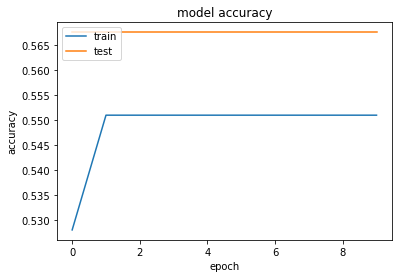

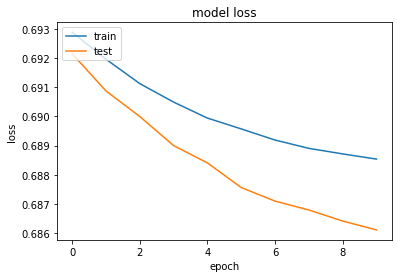

In [ ]:
plot_history(history_model2_LMST)

# Sérieursement

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, preprocessing
import tensorflow_datasets as tfds

def build_model():
    model = models.Sequential()
    # Input: - eEmbedding Layer.
    # The model will take as input an integer matrix of size (batch,     # input_length).
    # The model will output dimension (input_length, dim_embedding).
    # The largest integer in the input should be no larger
    # than n_words (vocabulary size).
    model.add(layers.Embedding(n_words,
    dim_embedding, input_length=max_len))
    model.add(layers.Dropout(0.3))
    # Takes the maximum value of either feature vector from each of     # the n_words features.
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model